In [2]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np

# REF_PATH : reference dataset path
# CONFUSION_PATH : benchmark1
# EXCHANGE_PATH : benchmark2

REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CONFUSION_PATH = "/home/yifan/dataset/confusion/pairflip/cifar10/0"
EXCHANGE_PATH = "/home/yifan/dataset/exchange/pairflip/cifar10/0"

sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
clean_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

confusion_provider = NormalDataProvider(CONFUSION_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

exchange_provider = NormalDataProvider(EXCHANGE_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)


ref_train_data = ref_provider.train_representation(200).squeeze()

confusion_data = confusion_provider.train_representation(200).squeeze()

exchange_data = exchange_provider.train_representation(200).squeeze()

clean_data = clean_provider.train_representation(200).squeeze()

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [3]:
import json
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
#=====benchmark1=========  ref: ref target: clean
with open('benchmark1_R_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark1_RT_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9402.92it/s]


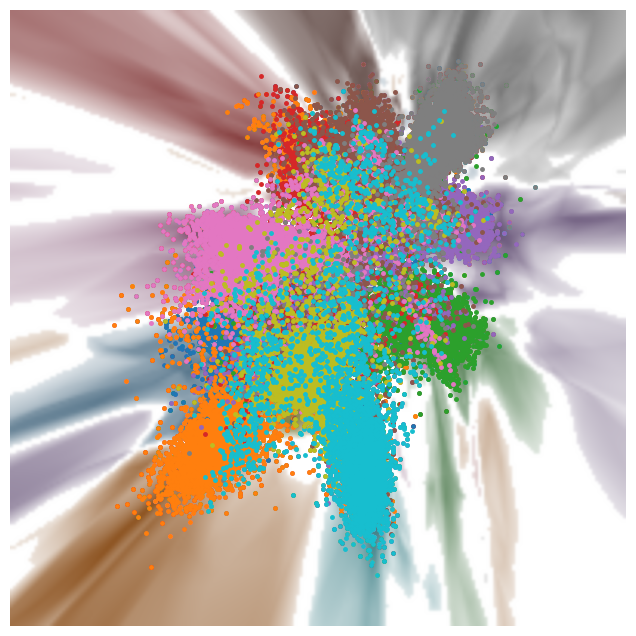

In [4]:
from representationTrans.trans_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_provider, RT,I, np.dot(clean_provider.train_representation(200),R), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [5]:
from representationTrans.eval.evaluator import Evaluator
pred_before = clean_provider.get_pred(200, ref_provider.train_representation(200))
pred_after = clean_provider.get_pred(200, np.dot(ref_provider.train_representation(200),RT))
eval = Evaluator(clean_provider, projector, pred_after)
diff = eval.evaluate_confidence(clean_provider.train_labels(200), pred_before, pred_after)
print('diff',diff)

100%|██████████| 250/250 [00:00<00:00, 9360.61it/s]

diff 23.191408


In [4]:
from representationTrans.eval.evaluator import Evaluator
pred_before = ref_provider.get_pred(200, ref_provider.train_representation(200))
pred_after = ref_provider.get_pred(200, ref_provider.train_representation(200))
eval = Evaluator(clean_provider, projector, pred_after)
diff = eval.evaluate_confidence(clean_provider.train_labels(200), pred_before, pred_after)
print('diff',diff)

100%|██████████| 250/250 [00:00<00:00, 9512.27it/s]

diff 0.0


In [4]:
from representationTrans.eval.evaluator import Evaluator
pred_before = ref_provider.get_pred(200, ref_provider.train_representation(200))
pred_after = ref_provider.get_pred(200, np.dot(clean_provider.train_representation(200),R))
eval = Evaluator(clean_provider, projector, pred_after)
diff = eval.evaluate_confidence(clean_provider.train_labels(200), pred_before, pred_after)
print('diff',diff)

100%|██████████| 250/250 [00:00<00:00, 9319.60it/s]

diff 4.185748


In [6]:
import json
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
#=====benchmark1=========  ref: ref target: clean
with open('benchmark2_RT_ref_clean_tar_ref_use_trans.json', 'r', encoding='utf-8') as file_obj:
    RV = json.load(file_obj)
from representationTrans.eval.evaluator import Evaluator
pred_before = ref_provider.get_pred(200, ref_provider.train_representation(200))
pred_after = ref_provider.get_pred(200, np.dot(clean_provider.train_representation(200),RV))
eval = Evaluator(clean_provider, projector, pred_after)
diff = eval.evaluate_confidence(clean_provider.train_labels(200), pred_before, pred_after)
print('diff',diff)

100%|██████████| 250/250 [00:00<00:00, 8742.65it/s]

diff 4.3085093


In [14]:
import json
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
#=====benchmark1=========  ref: ref target: clean
with open('benchmark2_RT_ref_clean_tar_ref_use_trans.json', 'r', encoding='utf-8') as file_obj:
    RV = json.load(file_obj)
from representationTrans.eval.evaluator import Evaluator
pred_before = ref_provider.get_pred(200, ref_provider.train_representation(200))
embed = projector.batch_project(200, ref_provider.train_representation(200))
grid_samples = projector.batch_inverse(200, embed)

pred_after = ref_provider.get_pred(200, grid_samples)
eval = Evaluator(clean_provider, projector, pred_after)
diff = eval.evaluate_confidence(clean_provider.train_labels(200), pred_before, pred_after)
print('diff',diff)

100%|██████████| 250/250 [00:00<00:00, 8705.05it/s]

diff 4.38124


In [9]:
emb = projector.batch_project(200, np.dot(clean_provider.train_representation(200),R))
diff = eval.eval_nn_test(200, np.dot(clean_provider.train_representation(200),R), emb, 10)

Fri Jan  6 20:33:13 2023 Building RP forest with 16 trees
Fri Jan  6 20:33:13 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	 9  /  16
	Stopping threshold met -- exiting after 9 iterations
Fri Jan  6 20:33:15 2023 Building RP forest with 16 trees
Fri Jan  6 20:33:15 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#test# nn preserving : 1.02/10 in epoch 200


In [11]:
emb = projector.batch_project(200, ref_provider.train_representation(200))
diff = eval.eval_nn_test(200, ref_provider.train_representation(200), emb, 15)

Fri Jan  6 20:33:45 2023 Building RP forest with 16 trees
Fri Jan  6 20:33:45 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Jan  6 20:33:46 2023 Building RP forest with 16 trees
Fri Jan  6 20:33:47 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#test# nn preserving : 1.26/15 in epoch 200


In [13]:
emb = projector.batch_project(200, np.dot(clean_provider.train_representation(200),R))
diff = eval.eval_nn_test(200, clean_provider.train_representation(200), emb, 15)

Fri Jan  6 20:36:44 2023 Building RP forest with 16 trees
Fri Jan  6 20:36:45 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Jan  6 20:36:46 2023 Building RP forest with 16 trees
Fri Jan  6 20:36:46 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#test# nn preserving : 1.05/15 in epoch 200


In [15]:
emb = projector.batch_project(200, np.dot(clean_provider.train_representation(200),RV))
diff = eval.eval_nn_test(200, clean_provider.train_representation(200), emb, 15)

Fri Jan  6 20:37:21 2023 Building RP forest with 16 trees
Fri Jan  6 20:37:21 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Fri Jan  6 20:37:23 2023 Building RP forest with 16 trees
Fri Jan  6 20:37:23 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#test# nn preserving : 1.04/15 in epoch 200


In [16]:
ref_pred = ref_provider.get_pred(200,  ref_provider.train_representation(200))
clean_pred = clean_provider.get_pred(200,  clean_provider.train_representation(200))
ref_pred = ref_pred.argmax(axis=1)
clean_pred = clean_pred.argmax(axis=1)
diff_list = []
for i in range(len(ref_pred)):
    if ref_pred[i] != clean_pred[i]:
        diff_list.append(i)
print(len(diff_list))


100%|██████████| 250/250 [00:00<00:00, 8952.16it/s]

71


In [21]:
before = ref_provider.get_pred(200,  ref_provider.train_representation(200))
after = ref_provider.get_pred(200,  np.dot(clean_provider.train_representation(200), R))
ref_pred = before.argmax(axis=1)
clean_pred = after.argmax(axis=1)
diff_list = []
for i in range(len(ref_pred)):
    if ref_pred[i] != clean_pred[i]:
        diff_list.append(i)
print(len(diff_list))

100%|██████████| 250/250 [00:00<00:00, 7808.06it/s]

1047


In [22]:
before = ref_provider.get_pred(200,  ref_provider.train_representation(200))
after = ref_provider.get_pred(200,  np.dot(clean_provider.train_representation(200), RV))
ref_pred = before.argmax(axis=1)
clean_pred = after.argmax(axis=1)
diff_list = []
for i in range(len(ref_pred)):
    if ref_pred[i] != clean_pred[i]:
        diff_list.append(i)
print(len(diff_list))

100%|██████████| 250/250 [00:00<00:00, 7769.70it/s]

1369
